In [119]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [120]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [121]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [122]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [123]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)


In [124]:
# Print all of the classes mapped to the Base
Base.classes.keys()


['station', 'measurement']

In [125]:
# Assign the measurement class to a variable called `Measurement` and
# assign the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [126]:
# Create a session
session = Session(engine)


# Exploratory Precipitation Analysis

In [127]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(most_recent_date)

2017-08-23


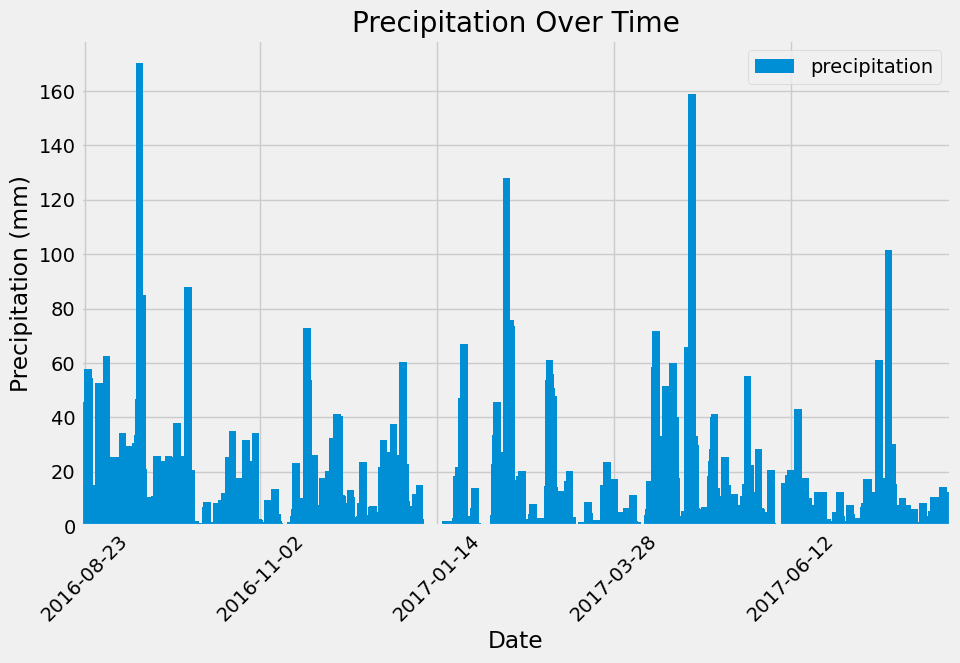

In [128]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
most_recent_date = session.query(func.max(Measurement.date)).scalar()

# Calculate the date one year from the last date in data set.
year_ago_date = session.query(func.strftime('%Y-%m-%d', func.date(most_recent_date, '-365 days'))).scalar()

# Perform a query to retrieve the data and precipitation scores
between_years = session.query(Measurement.date, Measurement.prcp) \
    .filter(Measurement.date >= year_ago_date) \
    .filter(Measurement.date <= most_recent_date)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(between_years, columns=['date', 'precipitation'])

# Sort the dataframe by date
df_sorted = precip_df.sort_values(by='date', ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
df_plot = df_sorted.plot(x='date', y='precipitation', kind='bar', figsize=(10, 6), width=20)

plt.title('Precipitation Over Time')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
df_plot.xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=15))

plt.xticks(rotation=45)

plt.show()

In [129]:
# Use Pandas to calculate the summary statistics for the precipitation data
Summed_stats = pd.DataFrame(df_sorted['precipitation'].describe(), columns=['precipitation'])

# Print the summary statistics
Summed_stats

,precipitation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [130]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(func.distinct(Measurement.station))).scalar()
total_stations

9

In [131]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)) \
    .group_by(Measurement.station) \
    .order_by(func.count(Measurement.station).desc()) \
    .all()

# List the stations and their counts in descending order.
for station, count in most_active_stations:
    print(f"('{station}', {count})")

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [132]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations[0][0]

temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)) \
    .filter(Measurement.station == most_active_station_id) \
    .all()
# Note, only added [] and () due to the example having them and my results not, purely visual
lowest_temp, highest_temp, avg_temp = temperature_stats[0]
print(f"[({lowest_temp}, {highest_temp}, {avg_temp})]")

[(12.2, 29.4, 22.03582251082252)]


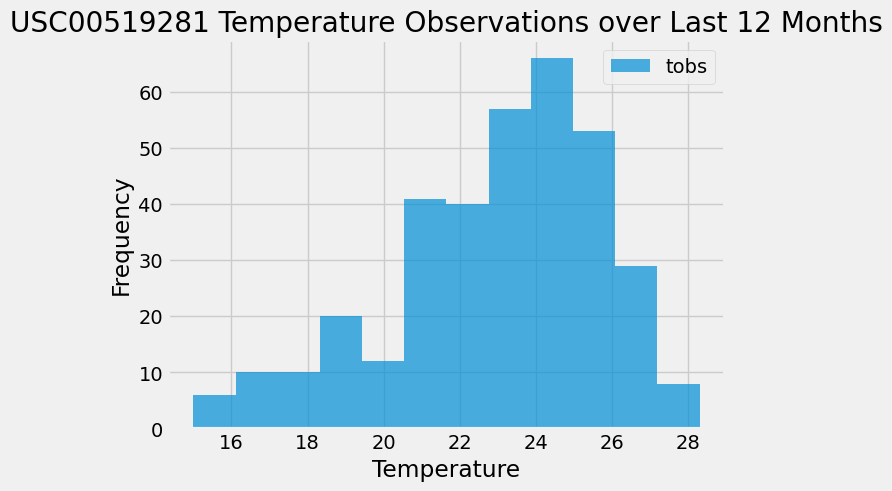

In [133]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_12_months_temps = session.query(Measurement.tobs) \
    .filter(Measurement.station == most_active_station_id) \
    .filter(Measurement.date >= year_ago_date) \
    .filter(Measurement.date <= most_recent_date) \
    .all()

temperatures = [temp[0] for temp in last_12_months_temps]

plt.hist(temperatures, bins=12, alpha=0.7, label="tobs")

plt.title('USC00519281 Temperature Observations over Last 12 Months')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Close Session

In [134]:
# Close Session
session.close()
